In [2]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

import cv2
import random

from IPython import display

# Por cada imagen cargada podemos obtener 4 tipos de imagenes

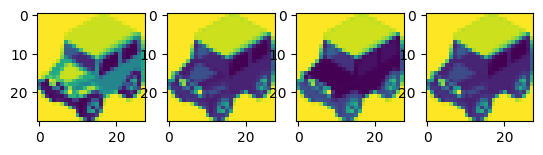

In [4]:
img = cv2.imread('./image/img_1.png', cv2.IMREAD_UNCHANGED)    

#make mask of where the transparent bits are
trans_mask = img[:,:,3] == 0

#replace areas of transparency with white and not transparent
img[trans_mask] = [255, 255, 255, 255]

#new image with rgb format
new_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Le cambias de tamaño 28 x 28
width = 28
height = 28
dim = (width, height)

Rsz_img = cv2.resize(new_img, dim, interpolation = cv2.INTER_AREA)
gray_img = cv2.cvtColor(Rsz_img, cv2.COLOR_BGR2GRAY)

# la divides en los colores R G B
R_img = Rsz_img[:,:,0]
G_img = Rsz_img[:,:,1]
B_img = Rsz_img[:,:,2]

_, arr = plt.subplots(1,4) # row, column  

arr[0].imshow(R_img)
arr[1].imshow(G_img)
arr[2].imshow(B_img)
arr[3].imshow(gray_img)

plt.show()

# Funciones de Imagenes

In [3]:
def rotar_imagen(imagen, grado):
    height, width = imagen.shape[:2]

    # get the center coordinates of the image to create the 2D rotation matrix
    center = (width/2, height/2)

    # using cv2.getRotationMatrix2D() to get the rotation matrix
    rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=grado, scale=1)

    # rotate the image using cv2.warpAffine
    rotated_image = cv2.warpAffine(src=imagen, M=rotate_matrix, dsize=(width, height))
    
    return rotated_image

# Prueba de la Funcion de imagen Rotar

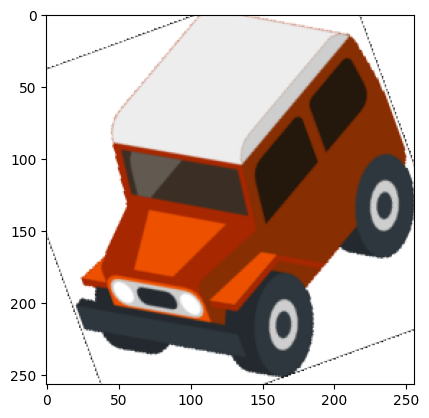

In [5]:
rotated_image = rotar_imagen(img, 20)

#make mask of where the transparent bits are
trans_mask = rotated_image[:,:,3] == 0

#replace areas of transparency with white and not transparent
rotated_image[trans_mask] = [255, 255, 255, 255]

rotated_image = cv2.cvtColor(rotated_image, cv2.COLOR_BGR2RGB)

plt.imshow(rotated_image)

plt.show()

# Data Aumentation

In [6]:
train_images = []

folder = './image'

angulo_rotacion = 25

#Por cada imagen cargada podemos conseguir 4 imagenes y adicionalmente si utilizamos la funcion de imagen rotar podemos crear
#"N" imagenes más según el valor de rotar por cada una de las 4 imagenes
for filename in os.listdir(folder):

    img = cv2.imread(os.path.join(folder,filename), cv2.IMREAD_UNCHANGED)
    
    if img is not None:
        
        #creando imagenes rotadas (data aumentation)
        for grado in range((-1*angulo_rotacion), (angulo_rotacion + 1)):
            
            rotated_image = rotar_imagen(img, grado)
        
            #make mask of where the transparent bits are
            trans_mask = rotated_image[:,:,3] == 0

            #replace areas of transparency with white and not transparent
            rotated_image[trans_mask] = [255, 255, 255, 255]

            #new image with rgb format
            new_img = cv2.cvtColor(rotated_image, cv2.COLOR_BGR2RGB)
        
            # Le cambias de tamaño 28 x 28
            width = 28
            height = 28
            dim = (width, height)

            Rsz_img = cv2.resize(new_img, dim, interpolation = cv2.INTER_AREA)
            gray_img = cv2.cvtColor(Rsz_img, cv2.COLOR_BGR2GRAY)

            # la divides en los colores R G B
            R_img = Rsz_img[:,:,0]
            G_img = Rsz_img[:,:,1]
            B_img = Rsz_img[:,:,2]
        
            R_img = np.asarray(R_img)
            G_img = np.asarray(G_img)
            B_img = np.asarray(B_img)
            gray_img = np.asarray(gray_img)
            
            train_images.append(R_img)
            
            comparison = R_img == G_img
            equal_arrays = comparison.all()
            
            if (not equal_arrays):
                train_images.append(G_img)
                
            comparison = R_img == B_img
            equal_arrays = comparison.all()
            
            comparison = B_img == G_img
            equal_arrays2 = comparison.all()
            
            if ((not equal_arrays) and (not equal_arrays2) ):
                train_images.append(B_img)

            comparison = R_img == gray_img
            equal_arrays = comparison.all()
            
            comparison = G_img == gray_img
            equal_arrays2 = comparison.all()
            
            comparison = B_img == gray_img
            equal_arrays3 = comparison.all()
            
            if ((not equal_arrays) and (not equal_arrays2) and (not equal_arrays3)):
                train_images.append(gray_img)

#ordenamos los valores de manera aleatoria
random.shuffle(train_images)

#convertimos el arreglo de imagenes a tipo arreglo de numpy
train_images = np.asarray(train_images)

#convertimos los valores de matriz de imagen de entero a floats
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

#convertimos los valores a valores normalizados de [-1, 1]
train_images = (train_images - 127.5) / 127.5

In [9]:
len(train_images)

241988

In [10]:
train_images[0].shape

(28, 28, 1)

# Building the Gan

In [11]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [12]:
# Este método devuelve una función auxiliar para calcular cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [13]:
def make_generator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None es el tamaño del Batch

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 28, 28, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [14]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [15]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [16]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [18]:
generator = make_generator_model()

In [19]:
discriminator = make_discriminator_model()

In [20]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [21]:
# Observe el uso de `tf.function`
# Esta anotación hace que la función sea "compilada".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    print('gen_loss: ' + str(gen_loss) + ' disc_loss: ' + str(disc_loss))

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [22]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

In [23]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [24]:
noise = tf.random.normal([1, 100])

In [25]:
generated_image = generator(noise, training=False)

In [26]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00094718]], shape=(1, 1), dtype=float32)


In [27]:
generated_image = np.squeeze(generated_image.numpy())
generated_image.shape

(28, 28)

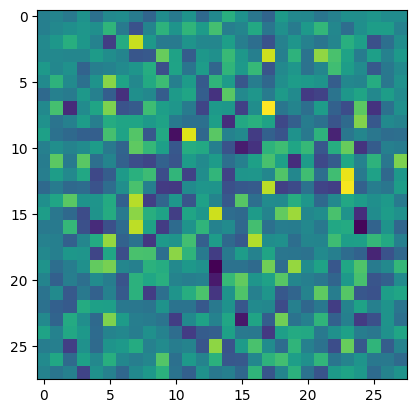

In [28]:
plt.imshow(generated_image)
plt.show()

# Entrenando el modelo

In [29]:
BUFFER_SIZE = 241784 #Este valor depende de la cantidad de imagenes que se crearon
BATCH_SIZE = 256

EPOCHS = 944 # Este valor depende del resultado entero entre la división del BUFFER_SIZE y el BATCH_SIZE
noise_dim = 100 # dimension de arreglos con ruido
num_examples_to_generate = 16 # numero de ejemplos que salen en la imagen resultado de muestra

In [30]:
# Agrupa los datos segun el tamaño del Batch y los ordena
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [31]:
# Reutilizaremos esta Seed en el tiempo (para que sea más fácil) para visualizar su progreso en la salida de imagenes
seed = tf.random.normal([num_examples_to_generate, noise_dim])

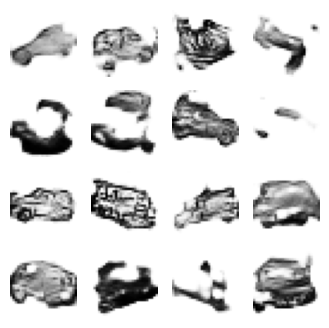

Time for epoch 112 is 490.65292096138 sec


In [ ]:
train(train_dataset, EPOCHS)

# Creación del video con las imagenes creadas

In [13]:
img_array = []

number_of_frame_per_second = 15

for filename in glob.glob('/image*.png'):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

# elegimos el codec de acuerdo al formato que se requiera
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
 
out = cv2.VideoWriter('./video/image_created_cars.avi', fourcc, number_of_frame_per_second, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])

out.release()